# NOT USED — accross channel is using index not distance

# Same as 14_line2line_spline but just 2 points left and right


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [2]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')

In [3]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()
    
def add_dDELAYdx(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dDELAY' and 'dDELAYdx' to the geodataframe
    """
    
    gdf['dDELAY'] = gdf.DELAY.diff().copy()
        
    gdf['dDELAYdx'] = gdf.dDELAY.to_numpy()/gdf.dx.to_numpy()

In [4]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2, ie one gdf for each line.

for line in bed_gdf[bed_gdf.camp =='KIS2'].line_name.unique().tolist():
    ll[line] = bed_gdf[(bed_gdf.line_name==line) & (bed_gdf.camp=='KIS2')].copy()
    ll[line].sort_values(by='x',inplace=True)
    ll[line].reset_index(drop=True,inplace=True)
    add_distance_to_gdf(ll[line])
    add_dDELAYdx(ll[line])
    

In [5]:
cross_channel_lines = [ 'line7p75','line7p5','line7p25','line7', 'line6','line5','lineAPREScross','line4']

In [6]:
#lines which cross the channel, (ll restricted to the above subset)
cl  = {key:ll[key] for key in cross_channel_lines}

### next do channel edges

In [7]:
# find the point at the edge of each channel, where dDELAYdx is over a certain threshold
channel_edges = {}
for key,value in cl.items():
    channel_edges[key] = [value[abs(value.dDELAYdx) > 20].index[0],
                          value[abs(value.dDELAYdx) > 20].index[-1]] 

In [8]:
#manually adjust
channel_edges['line7p75'][0]=114
channel_edges['line7p5'][0]=100
channel_edges['line7p25'][0]=147
channel_edges['line7'][0]=566
channel_edges['line6'][0]=544
channel_edges['line5'][0]=610
channel_edges['lineAPREScross'][0]=415
channel_edges['lineAPREScross'][1]=650
channel_edges['line4'][0]=710

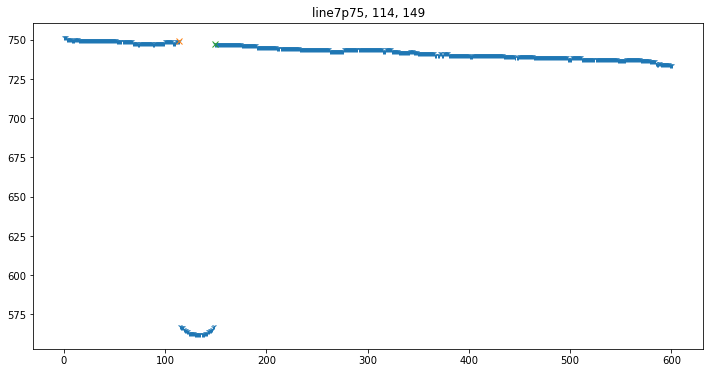

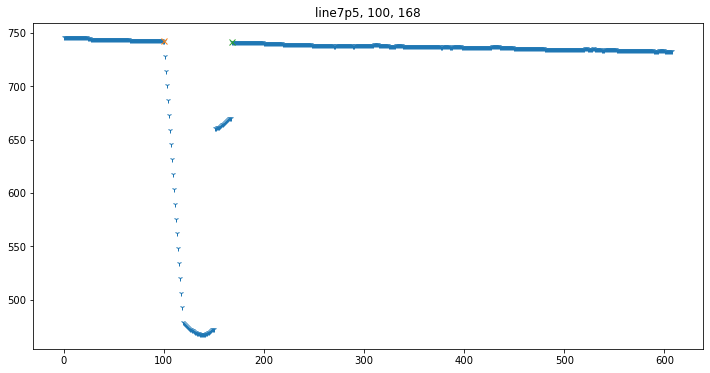

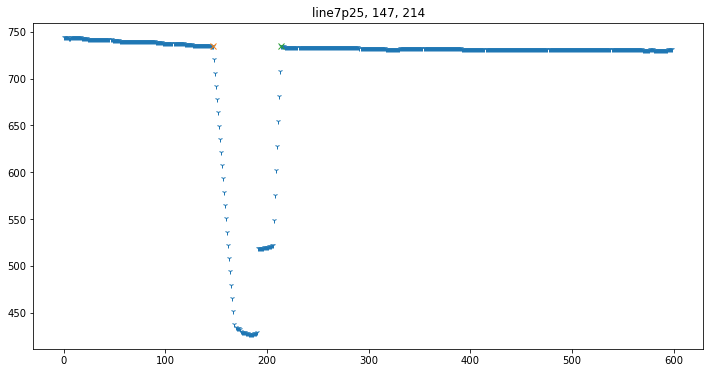

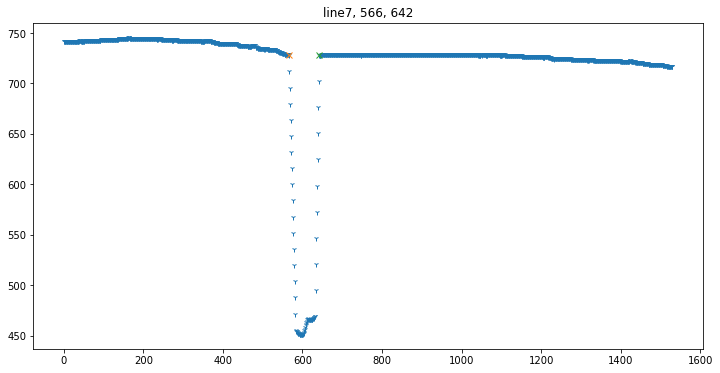

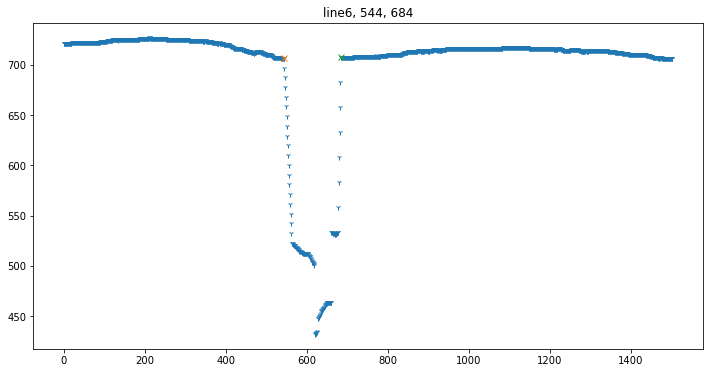

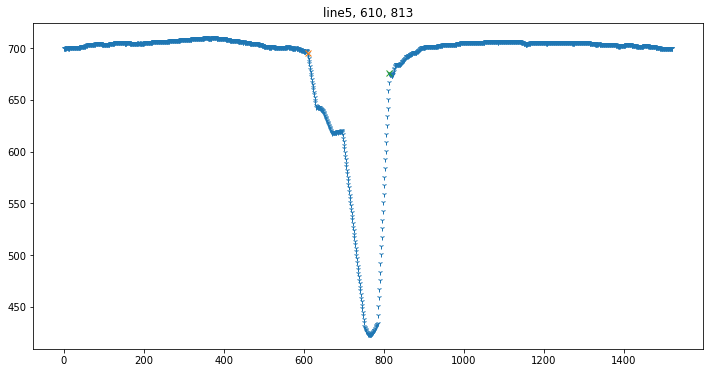

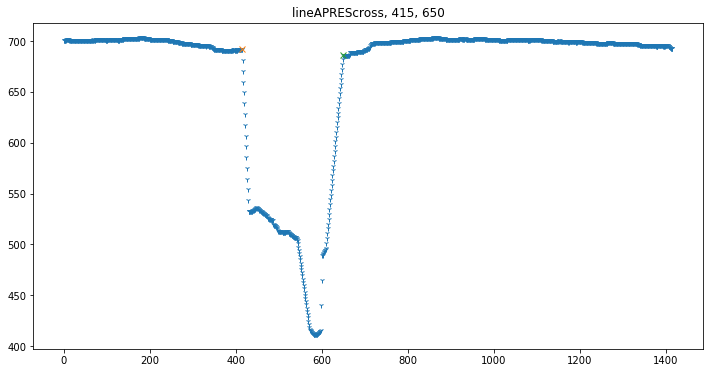

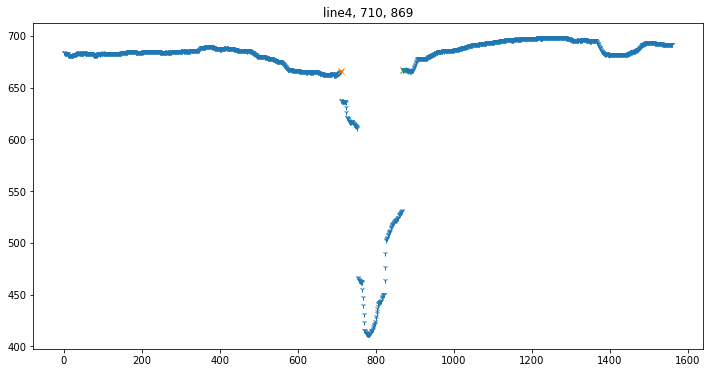

In [9]:
# double check we've picked the right bits.
for key,value in cl.items():
    plt.figure(figsize=(12,6))
    plt.plot(value.ice_thickn,'1')
    plt.plot(channel_edges[key][0],value.loc[channel_edges[key][0]].ice_thickn,'x')
    plt.plot(channel_edges[key][1],value.loc[channel_edges[key][1]].ice_thickn,'x')
    plt.title(f"{key}, {channel_edges[key][0]}, {channel_edges[key][1]}")
    plt.show()

In [10]:
#get just the channel part of the df
chan_dfs = {}
for key,value in cl.items():
    
    chan_dfs[key] = cl[key].loc[channel_edges[key][0]:channel_edges[key][1]] 
    chan_dfs[key].reset_index(drop=True,inplace=True)


In [11]:
#normalised_distance
for line,value in chan_dfs.items():
    chan_dfs[line]['normalised_distance'] = ((chan_dfs[line].distan_cum.copy() - chan_dfs[line].distan_cum.iloc[0])/
                                             (chan_dfs[line].distan_cum.iloc[-1] - chan_dfs[line].distan_cum.iloc[0]))

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [25]:
chan_dfs['line7'].keys()

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'SEQnum', 'camp',
       'time_UTC', 'ice_thickn', 'bed', 'geometry', 'dx', 'distan_cum',
       'dDELAY', 'dDELAYdx', 'normalised_distance'],
      dtype='object')

In [61]:
def interp_chan(gdf):
    """
    Input: Gdf with 'normalised_dist' as a column
    
    bin the ice thickness & coordinates in the channel
    
    Output: gdf only over the channel, all variables binned to certain cross channel intervals
    """
    
    f_x = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.x  ) #corresponding bins for each point
    f_y = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.y )
    f_ice_thickn = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.ice_thickn)
    f_surf = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.surf)
    f_bed = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.bed)
                           
    cc = np.linspace(0,1,20) #cross channel 
    
    gdf_out = pd.DataFrame({})
    gdf_out['x'] = f_x(cc)
    gdf_out['y'] =  f_y(cc)
    gdf_out['ice_thickn'] = f_ice_thickn(cc)
    gdf_out['surf'] = f_surf(cc)
    gdf_out['bed'] = f_bed(cc)
    
    geometry = [Point(xy) for xy in zip(gdf_out.x,gdf_out.y)]
    gdf_out = gpd.GeoDataFrame(gdf_out,geometry=geometry,crs="EPSG:3031")
    
    return gdf_out

In [62]:
#for every cross channel line, interpolate the channel and get values every 1/20th of the way along

c_interpd = {}

for key,value in chan_dfs.items():
    c_interpd[key] = interp_chan(value)

In [63]:
#vertical slice ( a column) is over one radar line
ice_thickn = np.array([value.ice_thickn.tolist() for value in c_interpd.values()]).T
points_x = np.array([value.x for value in c_interpd.values()]).T
points_y = np.array([value.y for value in c_interpd.values()]).T
#[line[0] for line in points] gets one point from each for points

# Now do 1D spline interpolation of the channel, one variable at a time

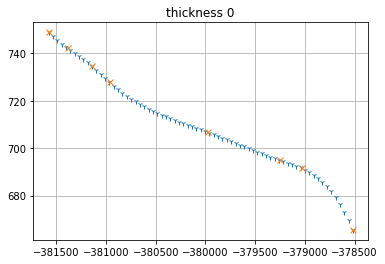

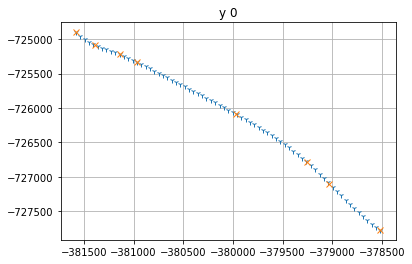

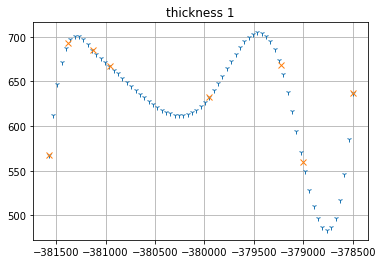

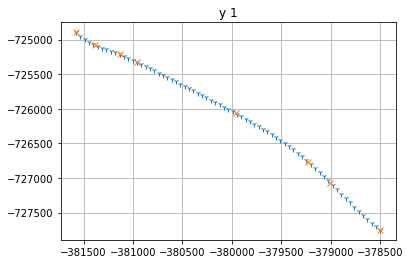

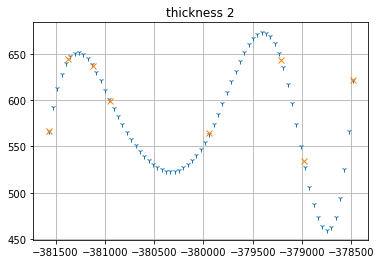

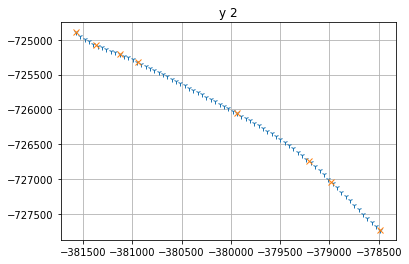

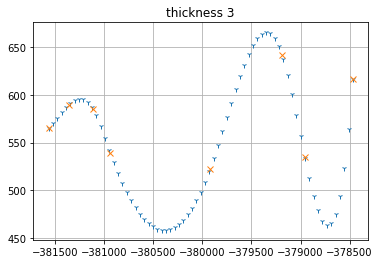

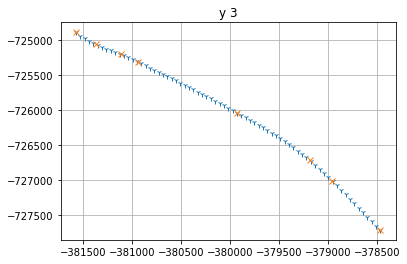

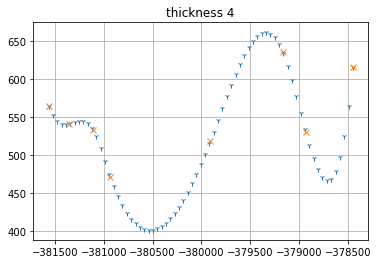

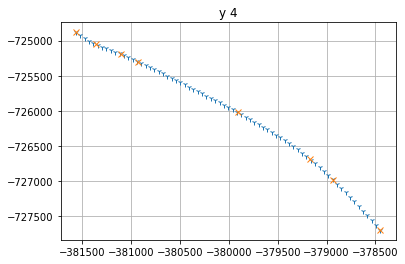

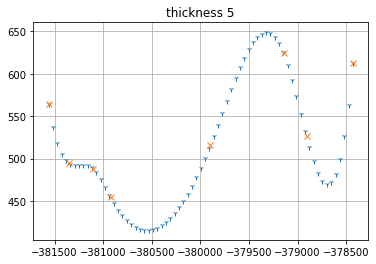

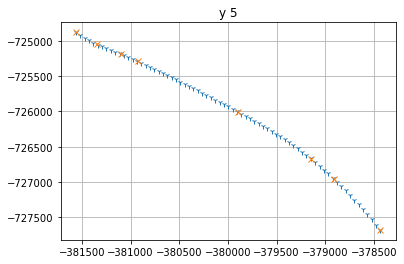

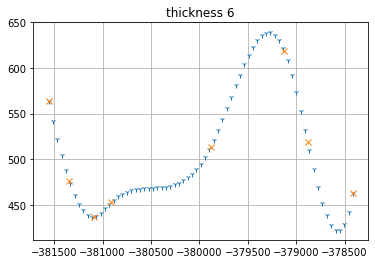

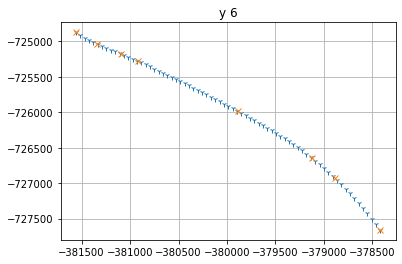

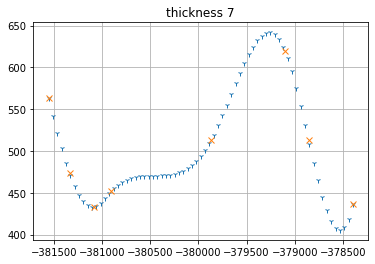

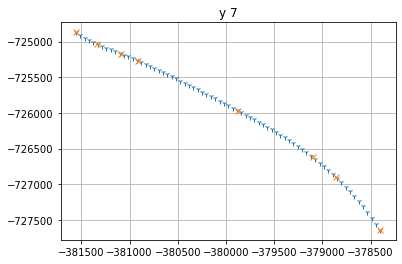

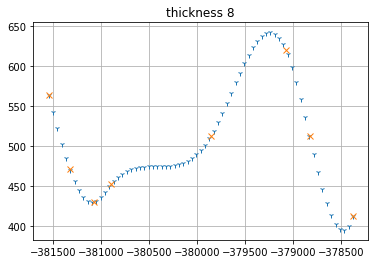

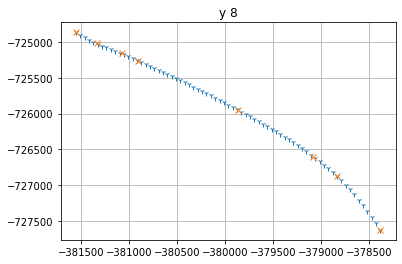

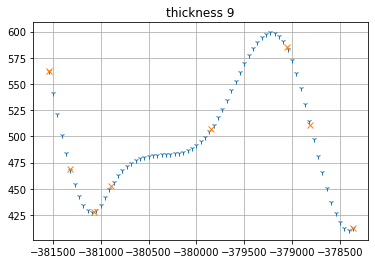

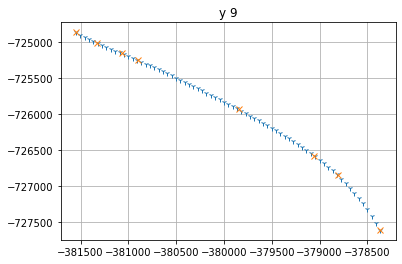

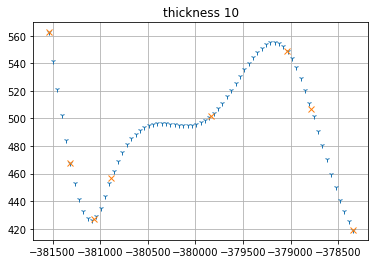

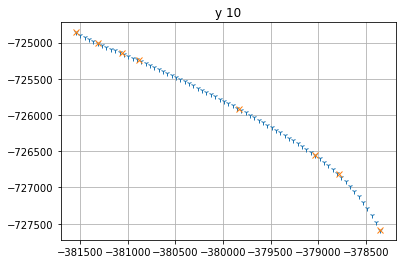

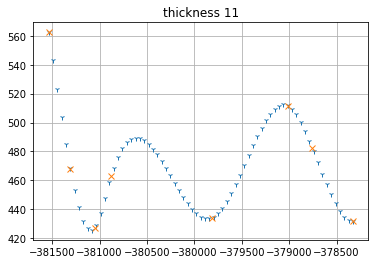

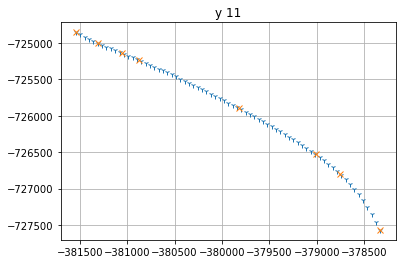

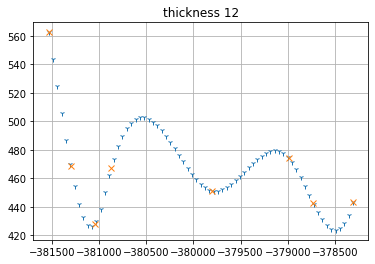

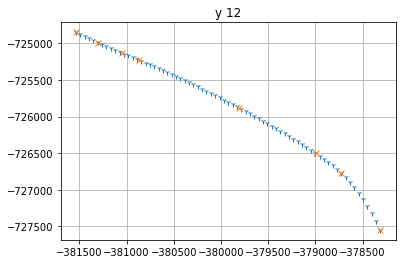

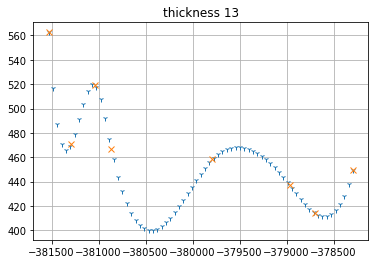

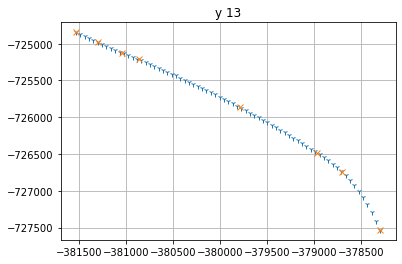

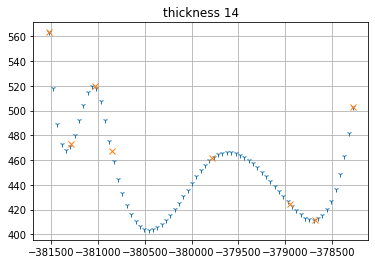

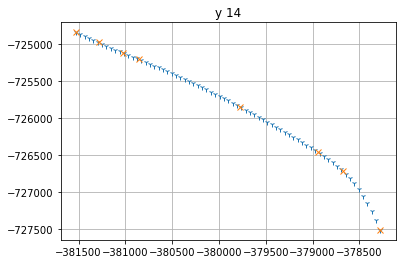

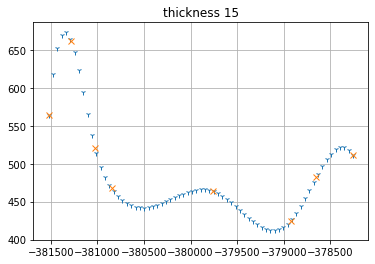

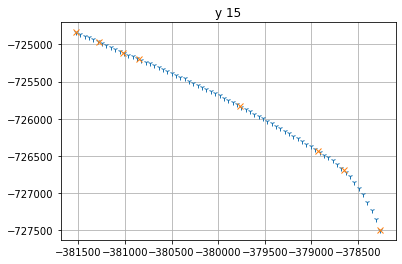

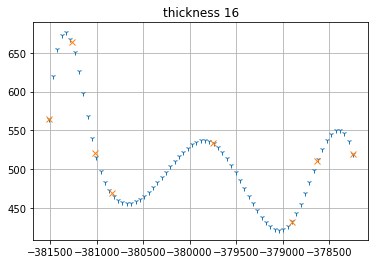

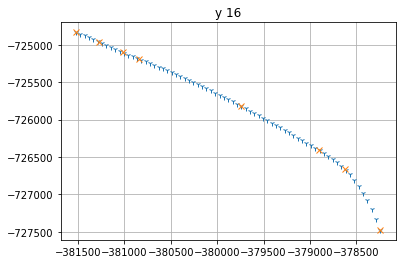

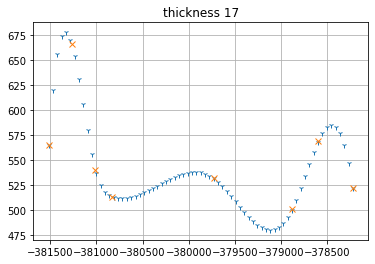

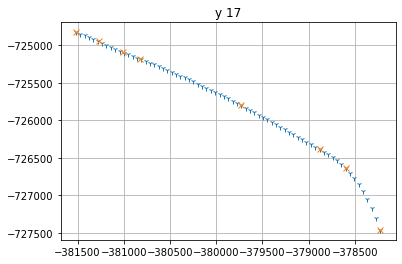

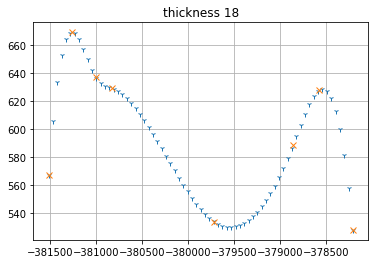

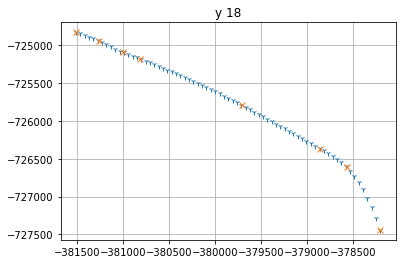

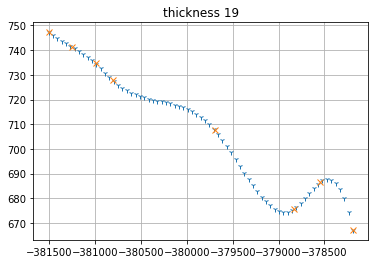

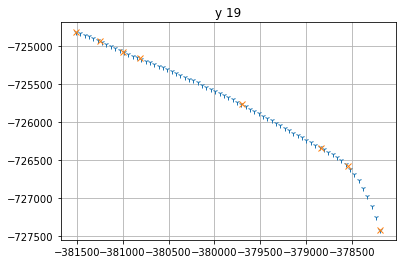

In [67]:
number_of_new_points = 9 # number_of_new_points to interpolate between existing points
new_length =  number_of_new_points*(points_x.shape[1]-1)+points_x.shape[1]  
ice_thickn_new = np.zeros([ice_thickn.shape[0], new_length])
points_x_new = ice_thickn_new.copy()
points_y_new = ice_thickn_new.copy()

for i in range(points_x.shape[0]):

    x = points_x[i,:]
    y = points_y[i,:]
    z = ice_thickn[i,:]

    # y_func = sp.interpolate.make_interp_spline(x, y)
    # z_func =sp.interpolate.make_interp_spline(x, z)
    x_new = np.linspace(points_x[i,:][0],points_x[i,:][-1],new_length)
    
    y_tck = sp.interpolate.splrep(x, y)
    z_tck = sp.interpolate.splrep(x, z)
#     z_tck = sp.interpolate.splrep(x, z,k=2,s=4000)
    
    y_new = sp.interpolate.splev(x_new, y_tck, der=0)
    z_new = sp.interpolate.splev(x_new, z_tck, der=0)
    
    points_x_new[i,:] = x_new
    points_y_new[i,:] = y_new
    ice_thickn_new[i,:] = z_new
    
    plt.figure()
    plt.plot(x_new,z_new,'1')
    plt.plot(x,z,'x')
    plt.grid()
    plt.title(f'thickness {i}')
    plt.show()
    
    plt.figure()
    plt.plot(x_new,y_new,'1')
    plt.plot(x,y,'x')
    plt.grid()
    plt.title(f'y {i}')
    plt.show()

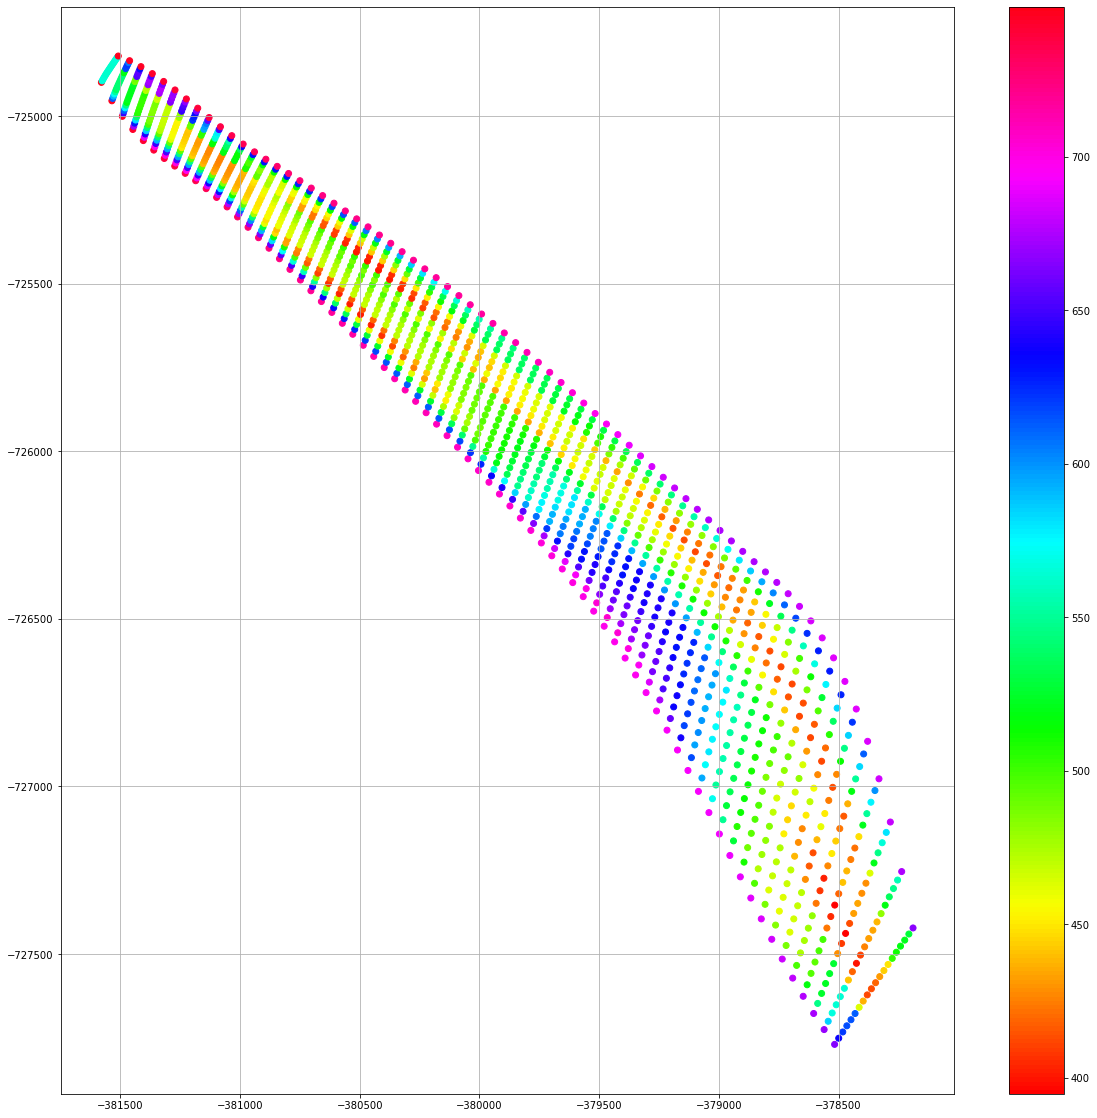

In [68]:
plt.figure(figsize=(20,20))
plt.scatter(points_x_new,points_y_new,c=ice_thickn_new,cmap='hsv')
plt.colorbar()
plt.grid()

# Plot cross sections

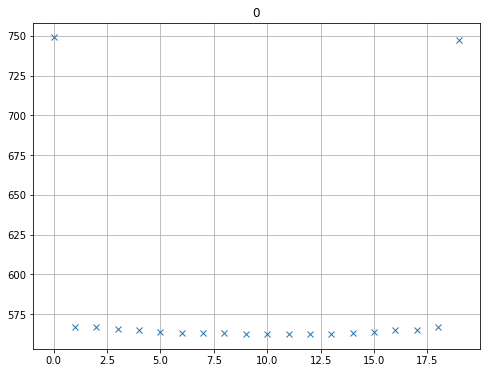

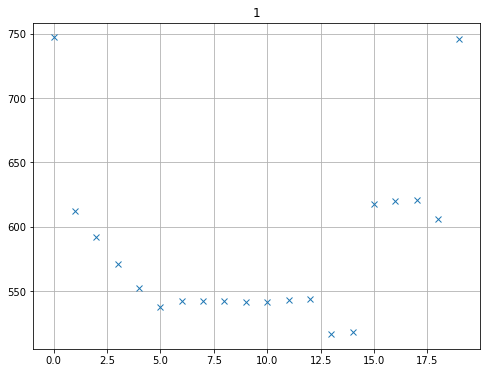

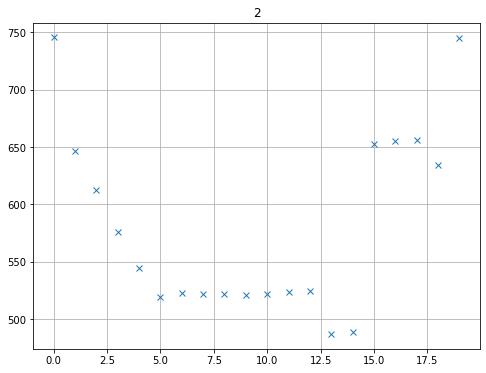

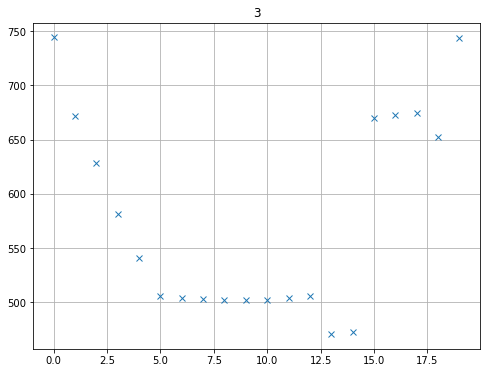

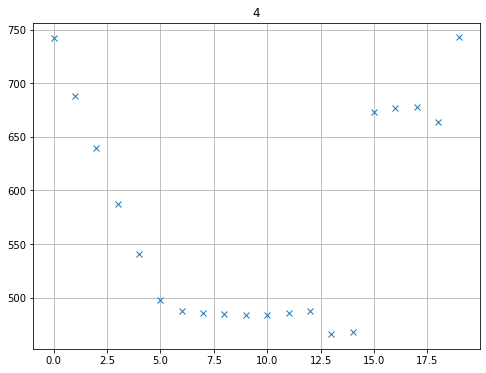

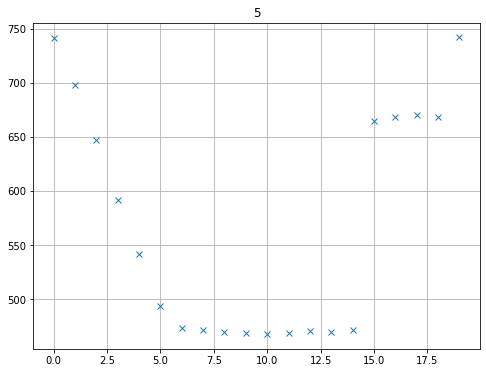

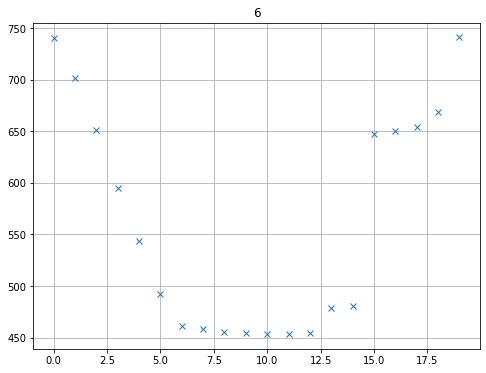

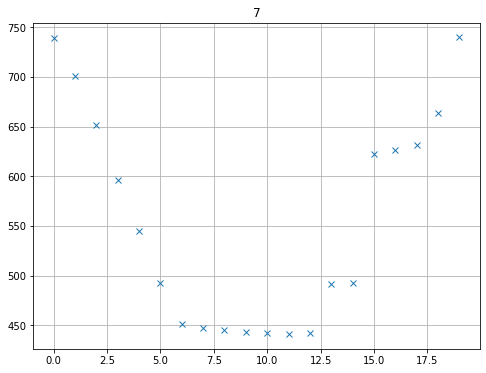

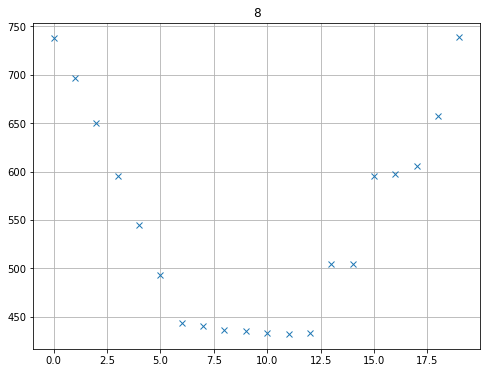

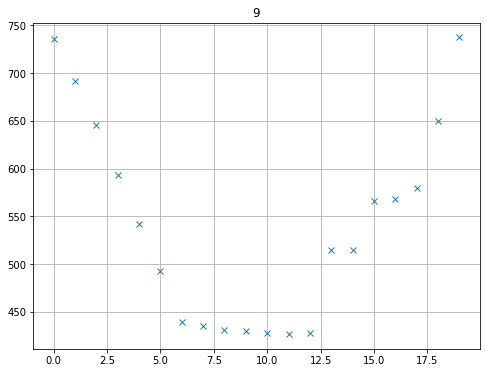

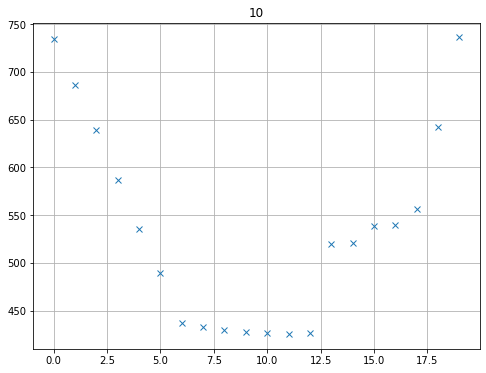

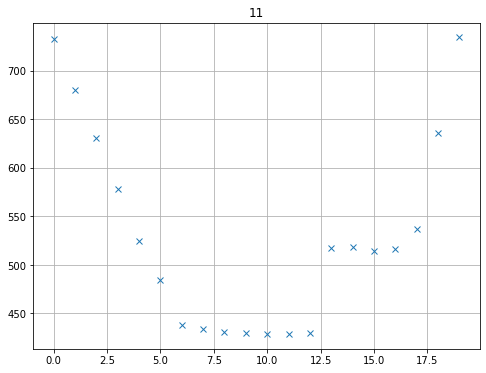

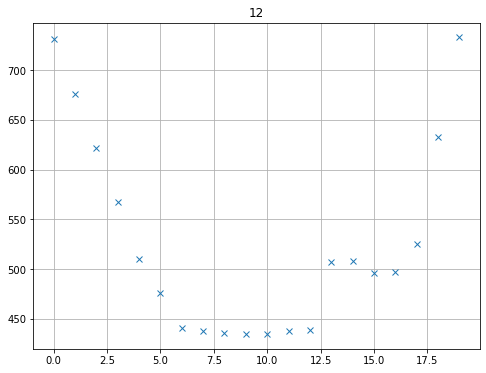

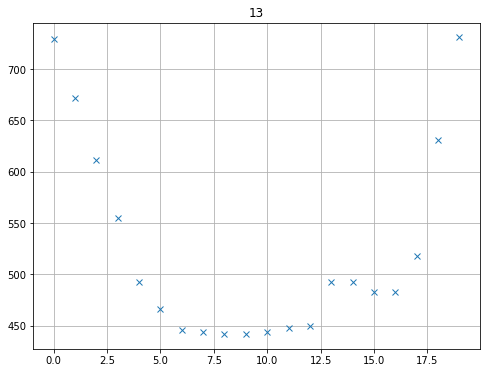

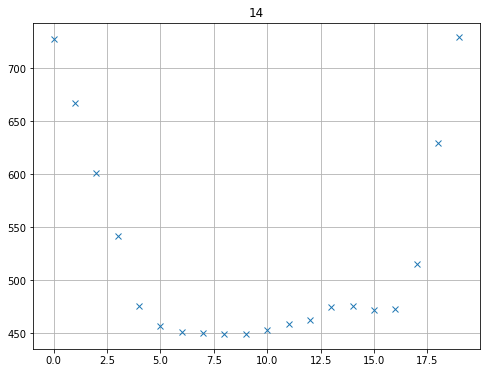

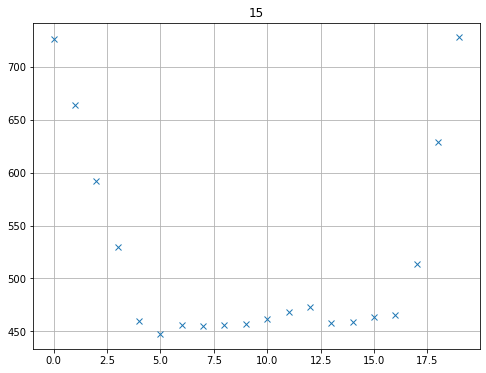

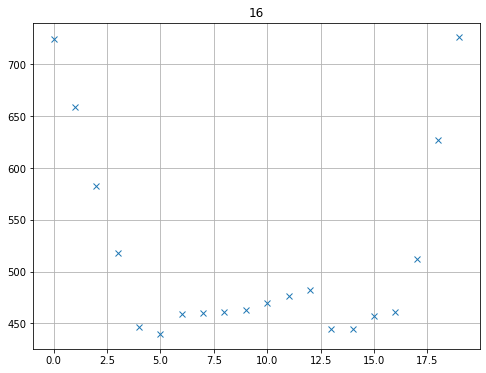

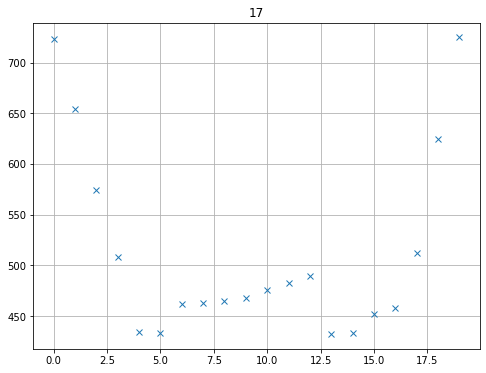

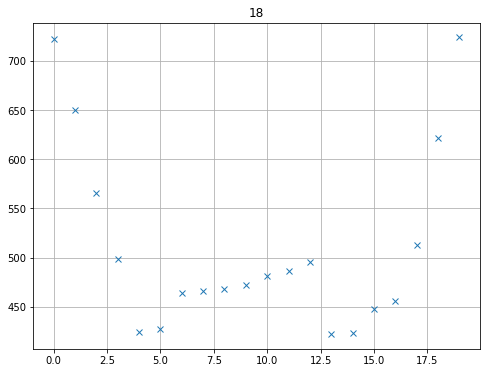

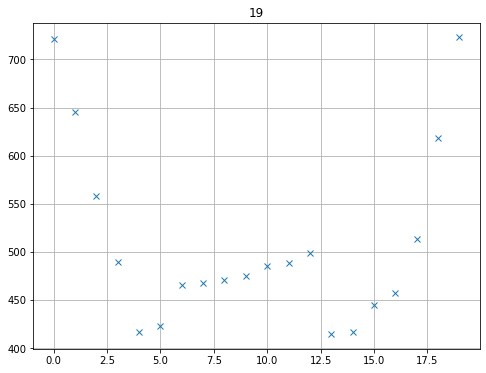

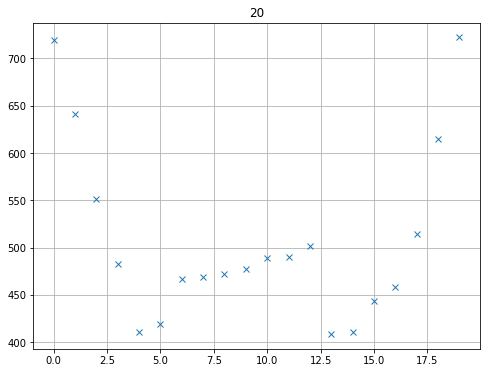

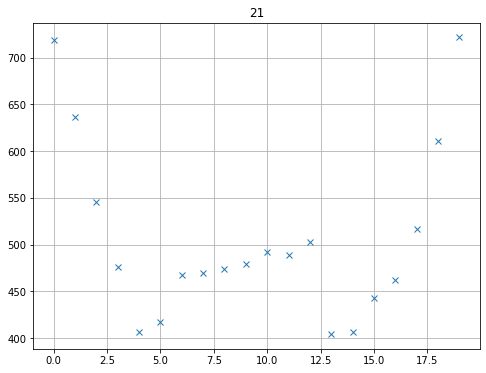

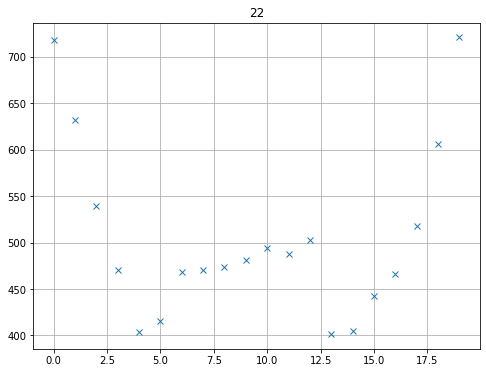

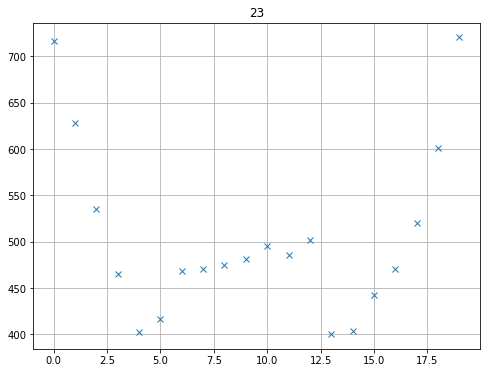

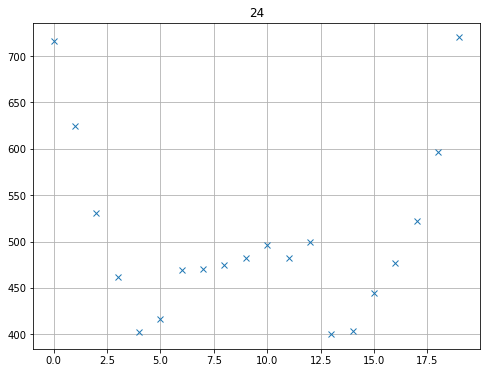

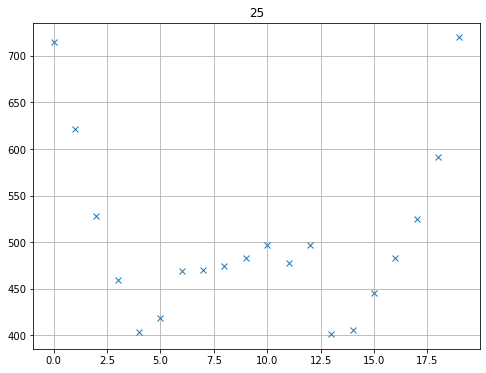

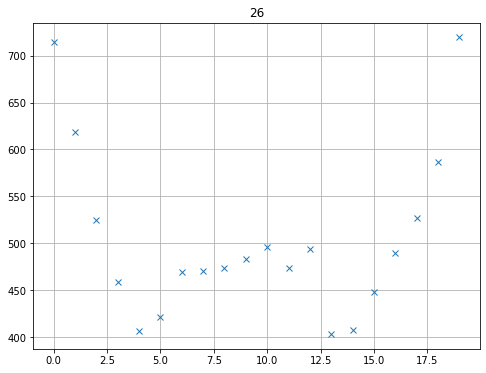

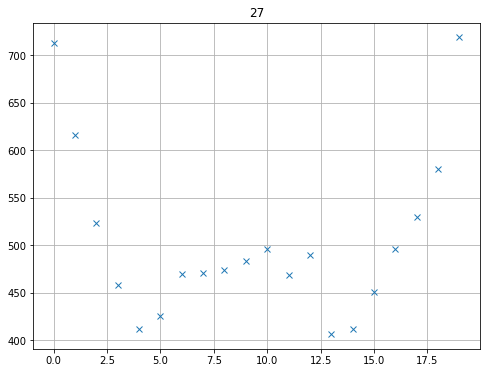

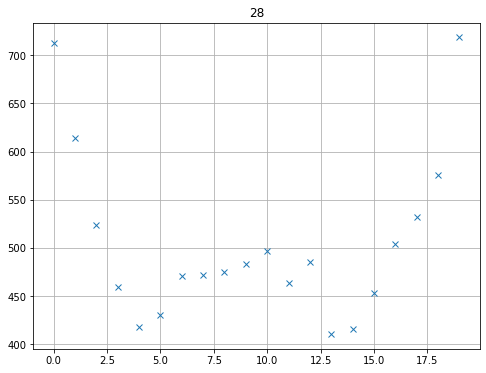

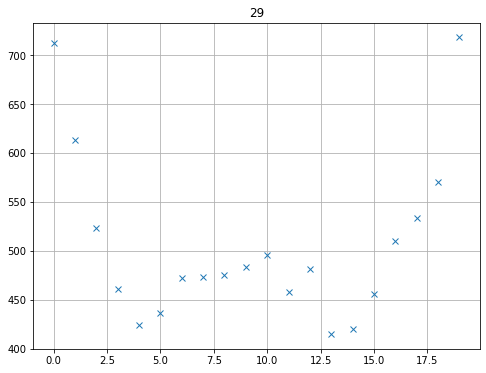

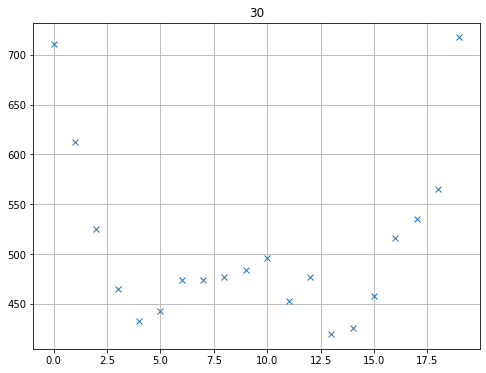

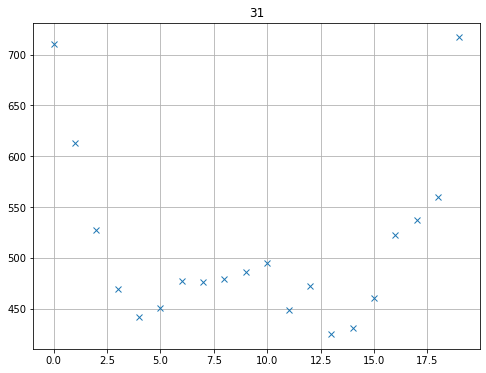

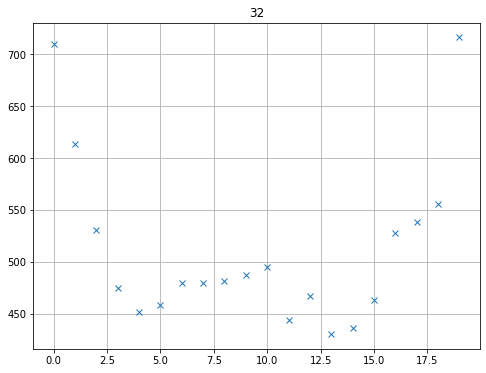

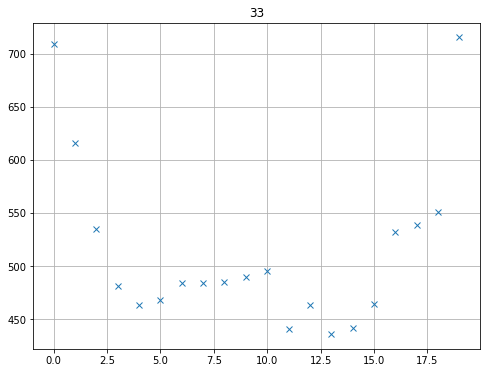

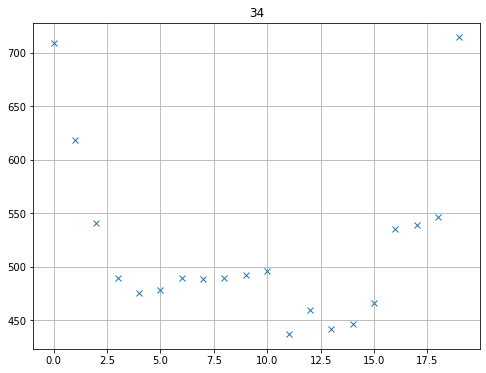

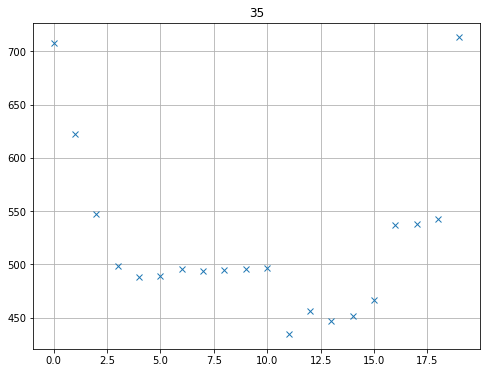

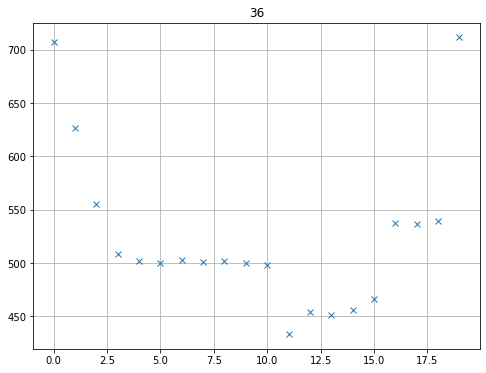

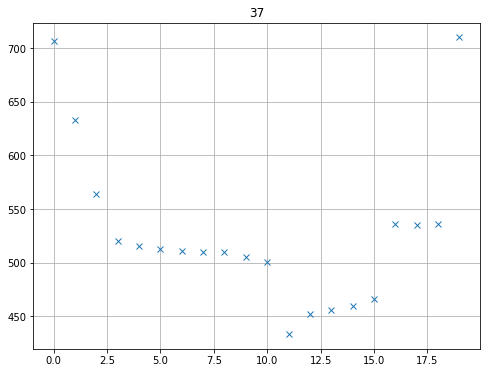

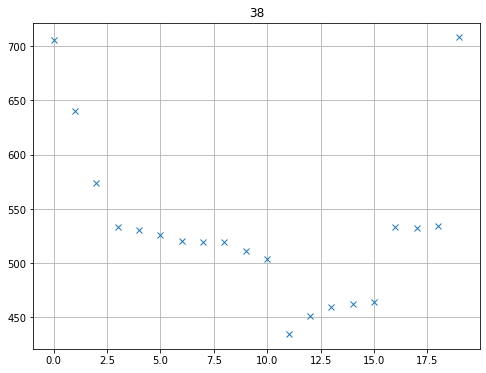

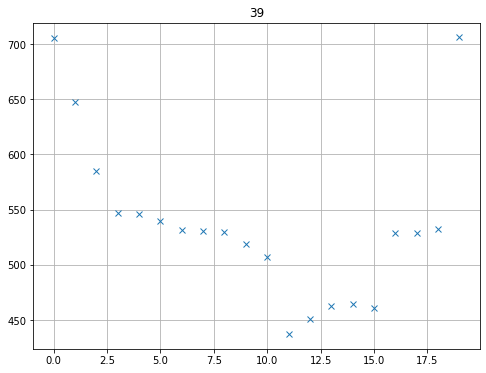

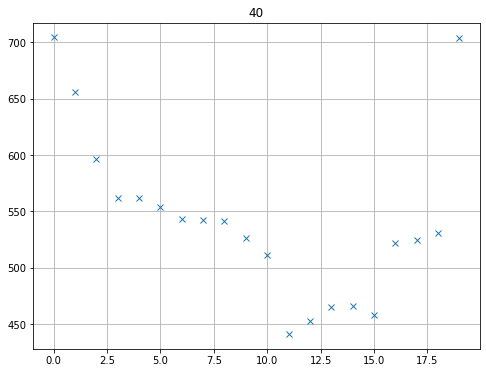

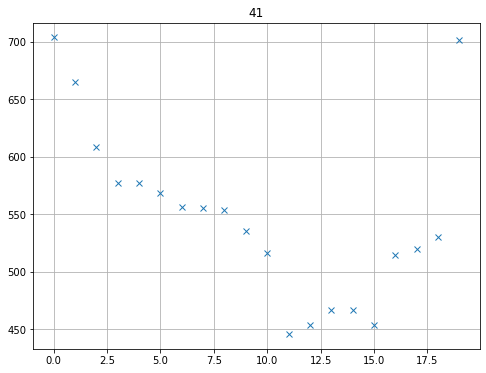

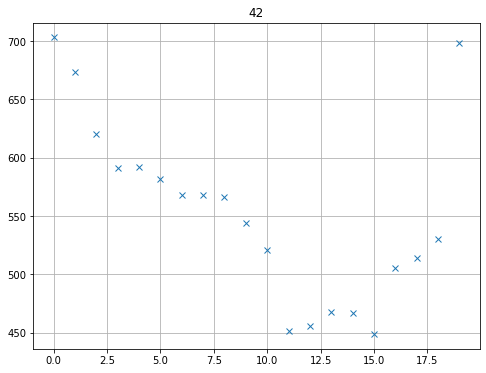

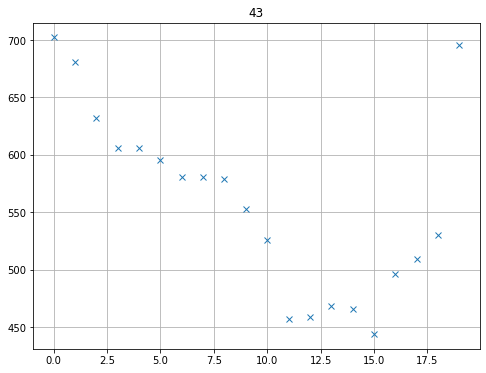

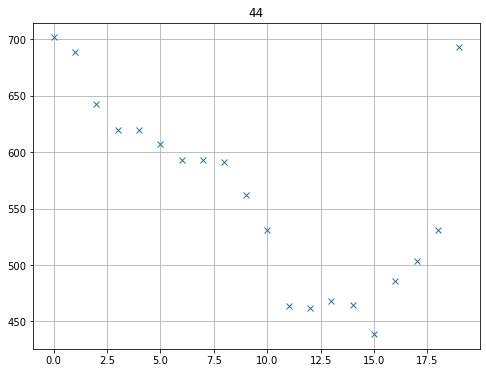

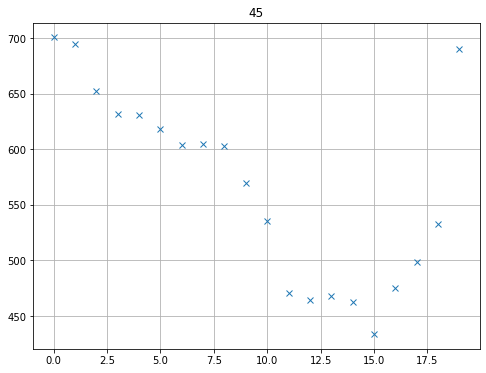

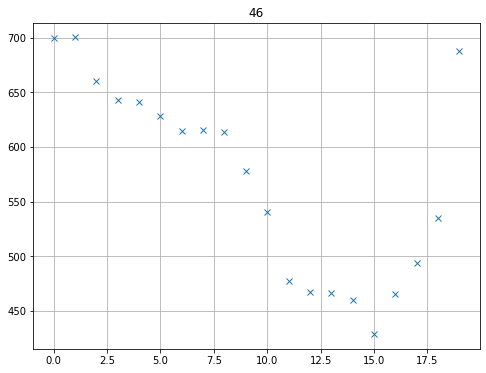

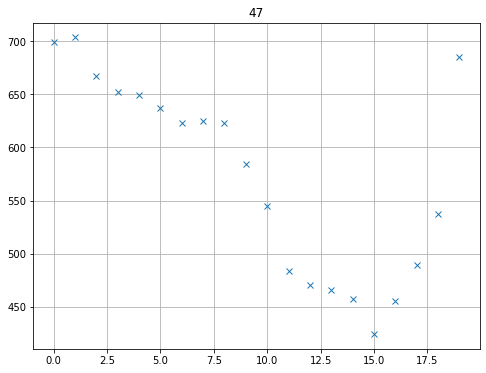

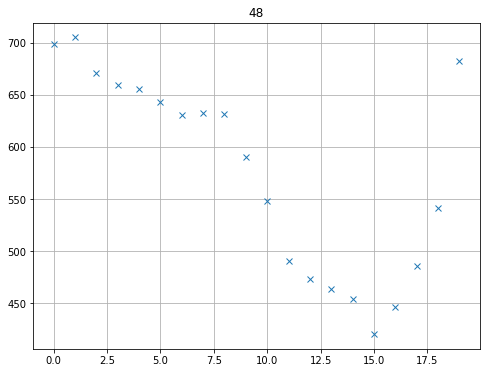

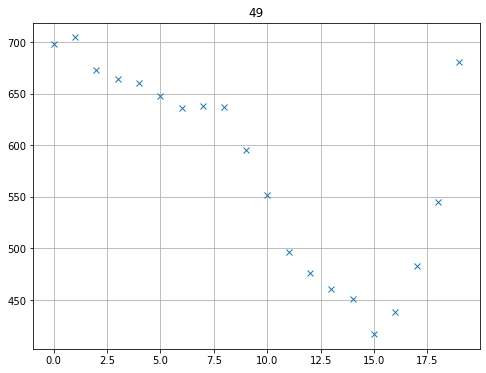

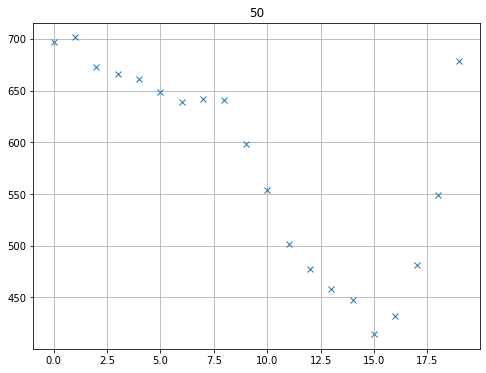

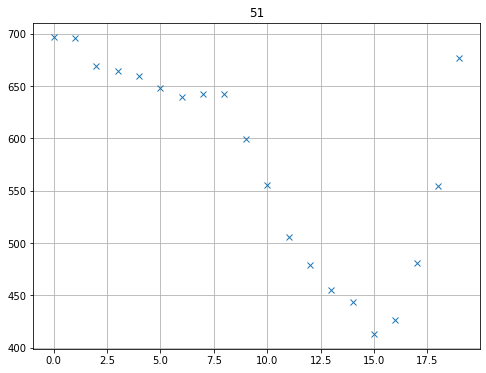

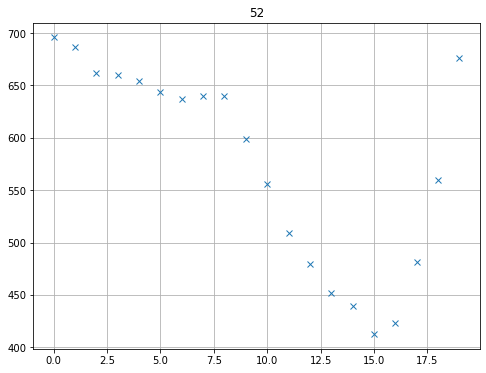

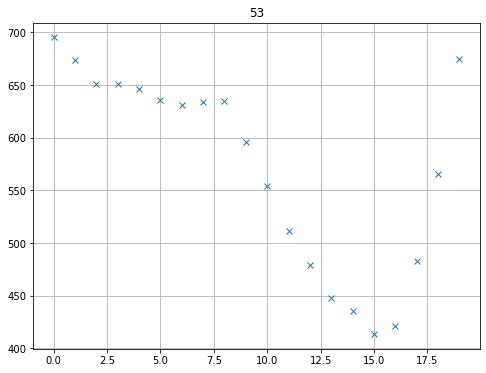

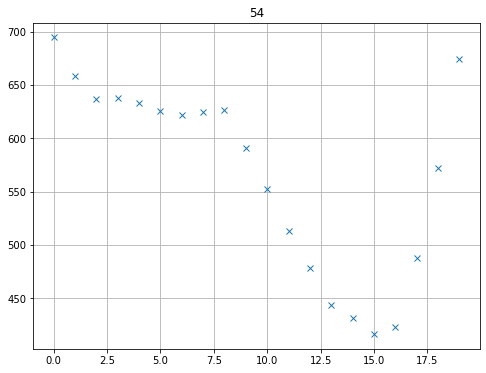

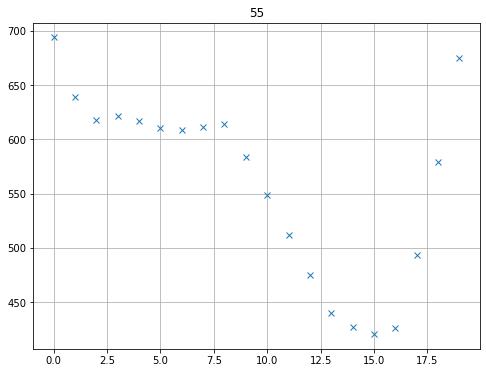

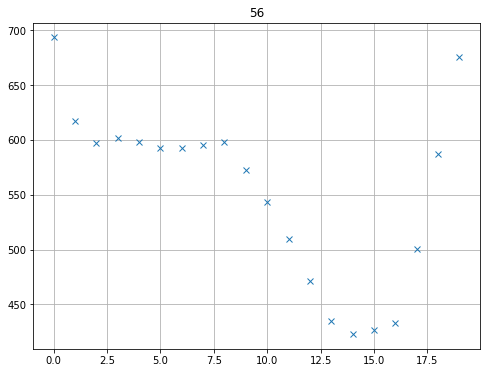

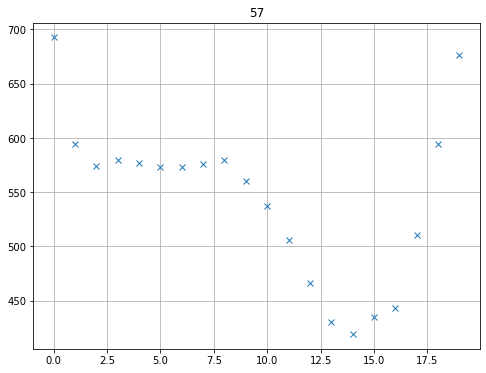

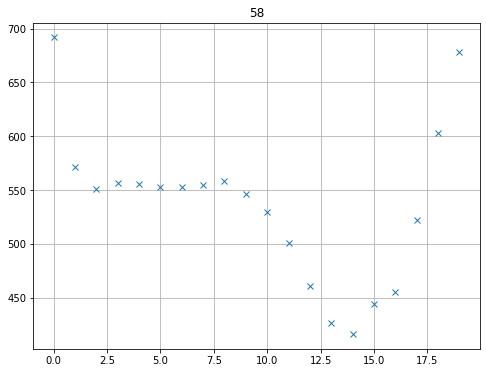

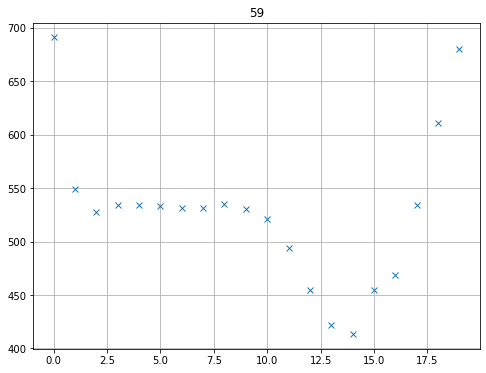

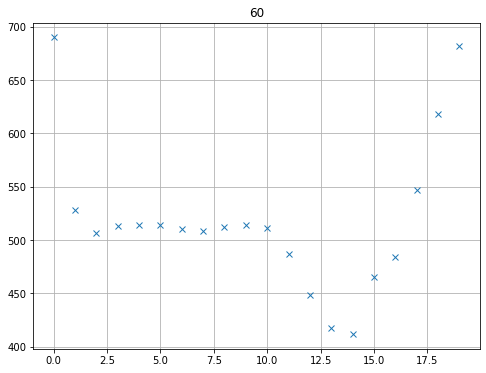

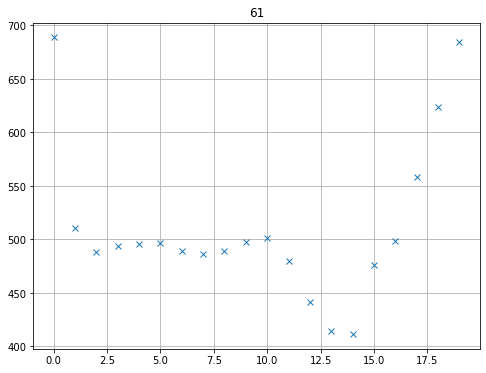

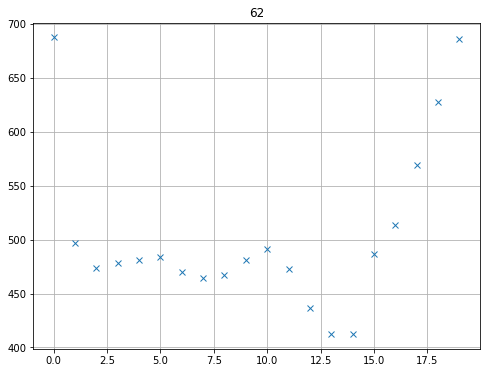

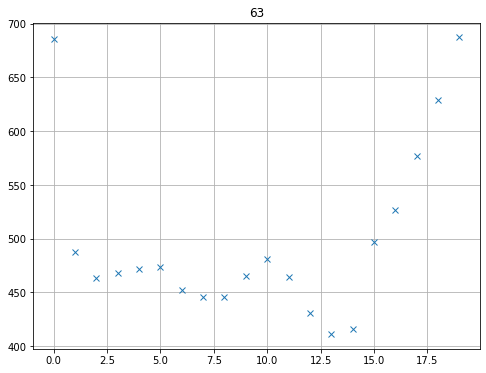

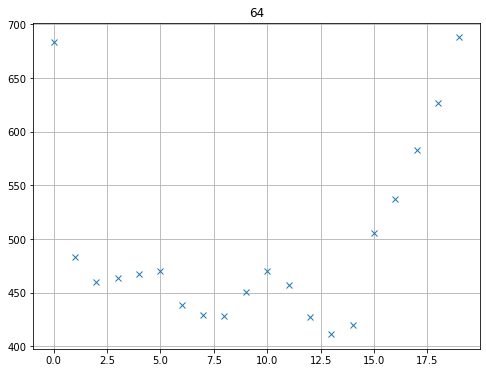

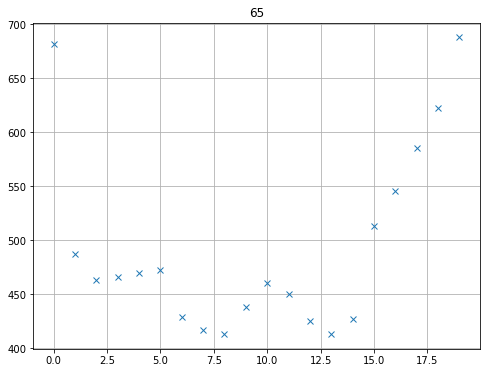

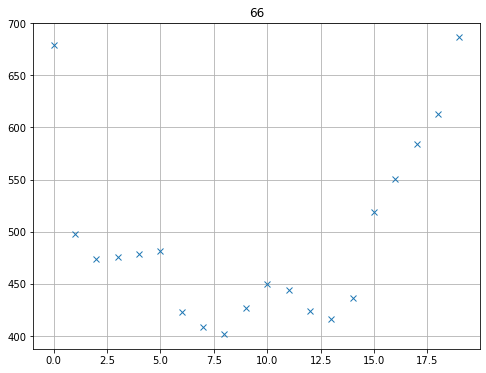

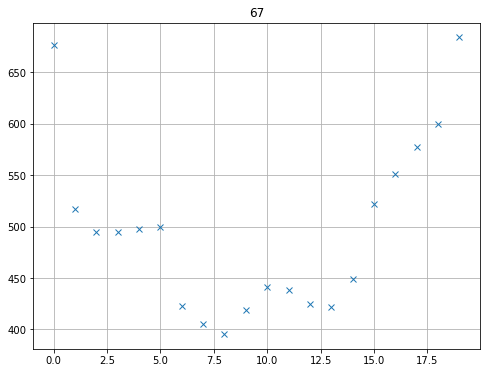

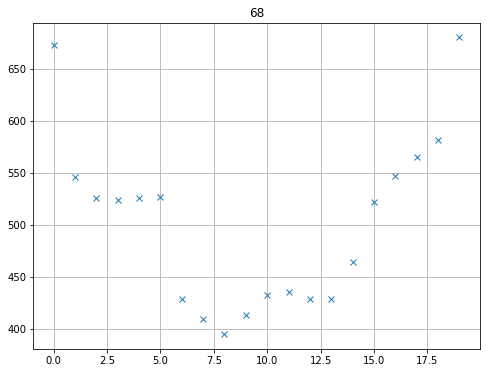

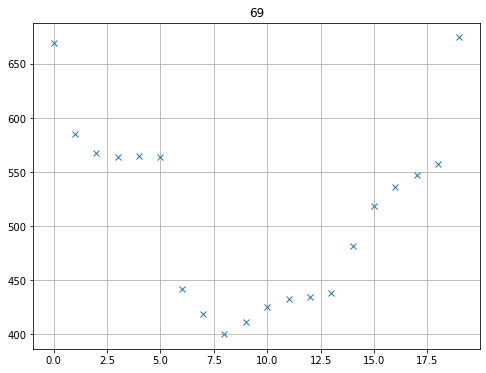

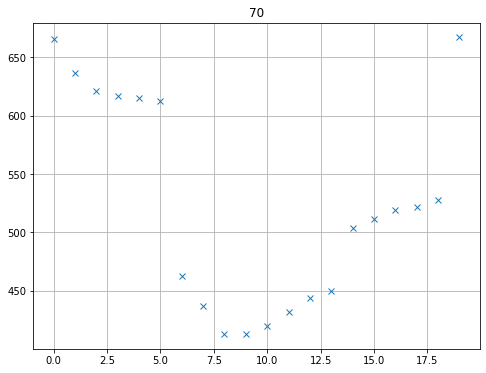

In [69]:
for i in range(ice_thickn_new.shape[1]):
    plt.figure(figsize=(8,6))
    plt.plot(ice_thickn_new[:,i],'x')
    plt.title(i)
    plt.grid()
    plt.show()

In [43]:
gdf = bed_gdf[bed_gdf.camp =='KIS2'].copy()

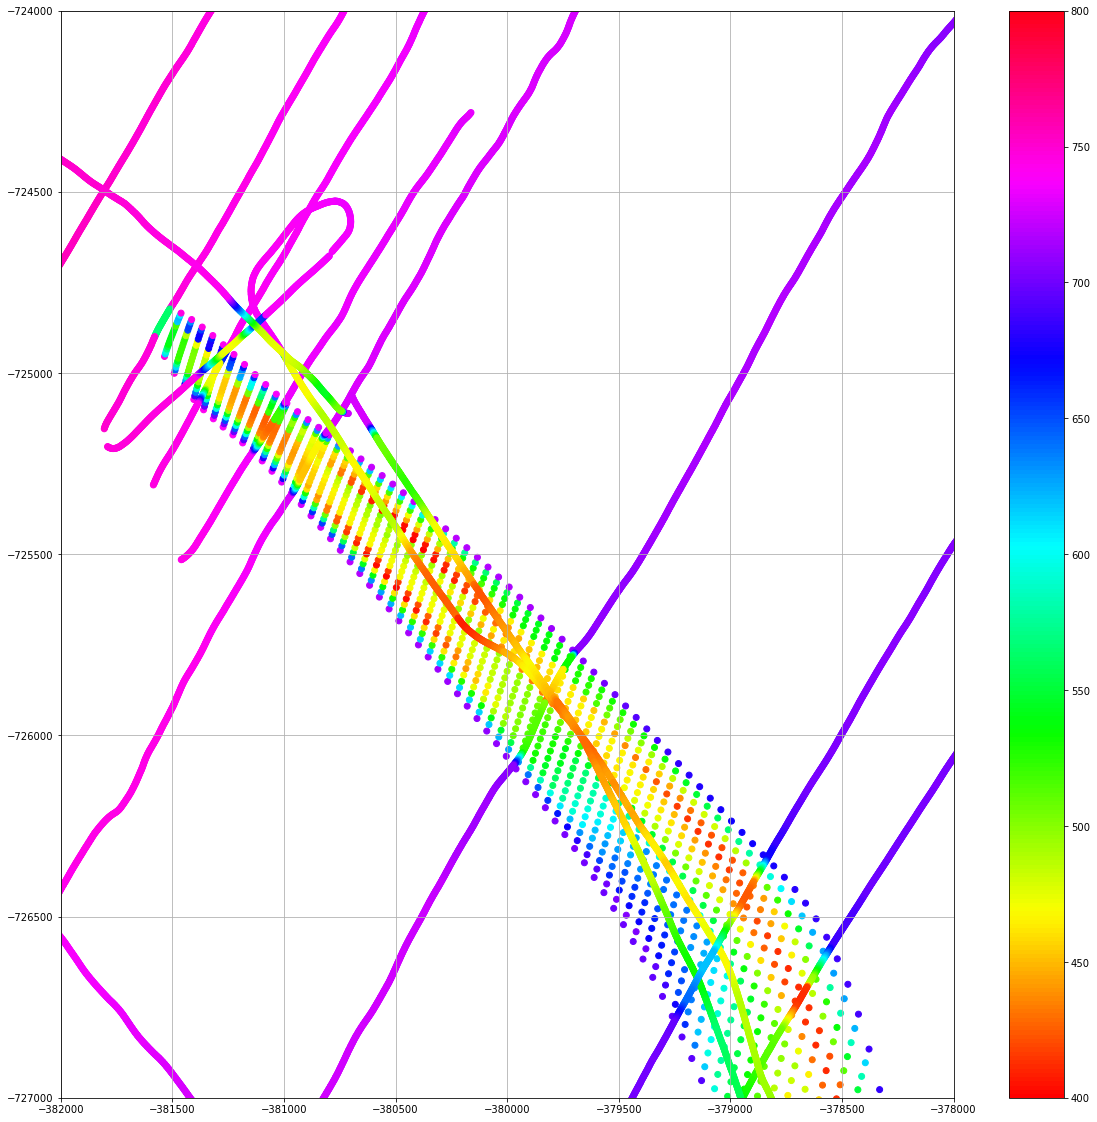

In [44]:
plt.figure(figsize=(20,20))
plt.scatter(points_x_new,points_y_new,c=ice_thickn_new,cmap='hsv',vmin=400, vmax=800)
plt.scatter(gdf.x,gdf.y,c=gdf.ice_thickn,cmap='hsv',vmin=400, vmax=800)
plt.xlim([-382000, -378000])
plt.ylim([-727000,-724000])
plt.colorbar()
plt.grid()

# This method:

isnt actually getting dots on the same points as the radar lines, because its putting them an equal distance apart down the whole channel

gets rooster tail douple incision between 6 and 7, i think we need the midline